$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

$\textbf{Preliminaries}$ 

The libraries used here are:

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from itertools import product
from multiprocessing import Pool
from ROOT import TCanvas
import matplotlib.pyplot as plt

## IMPORTANT: Make sure that "Uniandes_Framework" is in .gitignore
framework_path = "Uniandes_Framework"

if os.path.exists(framework_path):
    # Pull updates if the framework is already cloned
    try:
        subprocess.run(["git", "-C", framework_path, "pull"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while pulling updates from the framework: {e}")
else:
    # Clone the framework if it is not already cloned
    try:
        subprocess.run(["git", "clone", "git@github.com:Phenomenology-group-uniandes/Uniandes_Framework.git"])
    except subprocess.CalledProcessError as e:
        raise Exception(f"Error occurred while cloning the framework: {e}")
from Uniandes_Framework.delphes_reader.lhereader import LHE_Loader, readLHEF, get_event_by_child
from Uniandes_Framework.delphes_reader.root_analysis import get_kinematics_row, make_histograms, overlap_histos, Quiet, generate_csv, sum_histos, histos_matplotlib

Welcome to JupyROOT 6.22/06


hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
From github.com:Phenomenology-group-uniandes/Uniandes_Framework
 * [new branch]      new_features -> origin/new_features


Already up to date.


In [2]:
generation_options = {'e_e_virtual_contribution':  'generate p p > e+ e- $ z', 
                      'e_e_real_contribution': 'generate p p > z, z > e+ e-',
                      'e_e_total_contribution': 'generate p p > e+ e-'}

In [3]:
def read_xs_from_html(signal):

    html_path = os.path.join(os.getcwd(), signal, 'crossx.html')
    html_table = pd.read_html(html_path)
    column_xs = html_table[0]['Cross section (pb)']
    return float(column_xs[0].split(' ')[0])    

csv_initial = pd.read_csv(os.path.join('Uniandes_Framework', 'SimulationsPaths.csv'))

csv_final = pd.concat(
                        [csv_initial]
                        +
                        [ pd.DataFrame.from_dict(
                        {
                            'name': signal, 
                            'path': os.path.join(os.getcwd(), signal),  
                            'xs(pb)': read_xs_from_html(signal)
                        }, 
                        orient = 'index').T for signal in generation_options.keys()]
                     )

# save the new csv
csv_final.to_csv('SimulationsPaths.csv', index = False)

In [8]:
def read_lhe_file(signal_key):
        
    lhe_loader = LHE_Loader(signal_key, os.path.join(os.getcwd(), 'SimulationsPaths.csv'))
    lhe_path_file = lhe_loader.Forest[0]
    
    # print(lhe_path_file)
    
    childs=readLHEF(lhe_path_file)
    
    results = list()
    
    for child in childs:
        event = get_event_by_child(child)
        electrons = event.getParticlesByIDs([-11,11])
        if len(electrons) != 2: continue
        electrons[0].SetName("#electron_{1}")
        electrons[1].SetName("#electron_{2}")
        sum_electrons = electrons[0].TLV + electrons[1].TLV
        row = get_kinematics_row(electrons)
        row["m_ll(GeV)"] = sum_electrons.M()
        row["sT(GeV)"] = row["pT_{#electron_{1}}(GeV)"] + row["pT_{#electron_{2}}(GeV)"]
        results.append(row)        
    
    generate_csv(results, os.path.join(signal_key, 'Kinematic_Information.csv'))

In [9]:
with Pool(3) as p: p.map(read_lhe_file, generation_options.keys())

e_e_total_contribution imported with 0 trees!
/disco4/personal_folders/Joaquin/2023/Semanas_19_20_21/ta_ta_generation_testing/e_e_total_contribution
e_e_virtual_contribution imported with 0 trees!
/disco4/personal_folders/Joaquin/2023/Semanas_19_20_21/ta_ta_generation_testing/e_e_virtual_contribution
e_e_real_contribution imported with 0 trees!
/disco4/personal_folders/Joaquin/2023/Semanas_19_20_21/ta_ta_generation_testing/e_e_real_contribution


In [12]:
Kinematic_information = {}

for signal in generation_options.keys(): Kinematic_information[signal] = pd.read_csv(os.path.join(signal, 'Kinematic_Information.csv'))

In [24]:
default_hist_bins_dict={
    "#Delta{R}":[96,0,7],
    "#Delta{#eta}":[80,-5,5],
    "#Delta{#phi}":[52,-3.25,3.25],
    "#Delta{pT}":[120, 0.0, 1500.0],
    "#Delta{#vec{pT}}":[240, 0.0, 4800.0],
    "#Delta{#vec{p}}":[240, 0.0, 4800.0],
    "MET(GeV)":[80, 0.0, 1000.0],
    "pT_": [160, 0.0, 2000.0],
    "sT(GeV)": [200, 0.0, 4000.0],
    "mT(GeV)": [200, 0.0, 4000.0],
    "#eta_":[80, -5, 5],
    "#phi_":[128, -3.2, 3.2],
    "Energy_":[80, 0.0, 1000.0],
    "m_ll(GeV)" : [100, 0, 1000.0]
}

In [59]:
Histograms = {'total': {}, 'real': {}, 'virtual': {}, 'virtual + real': {},'(virtual + real)/total': {}, 'virtual/total': {}}

Histo_Total = make_histograms(Kinematic_information['e_e_total_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('e_e_total_contribution'))
Histo_Virtual = make_histograms(Kinematic_information['e_e_virtual_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('e_e_virtual_contribution'))
Histo_Real = make_histograms(Kinematic_information['e_e_real_contribution'], hist_bins_dict = default_hist_bins_dict, integral = read_xs_from_html('e_e_real_contribution'))

# Histograms['total'] = Histo_Total
# Histograms['virtual'] = Histo_Virtual
# Histograms['real'] = Histo_Real

for key in Histo_Total.keys(): 
    
    Histo_sum = sum_histos([Histo_Virtual[key], Histo_Real[key]])
    
    # Histograms['virtual + real'][key] = Histo_sum
    # Histograms['(virtual + real)/total'][key] = Histo_sum/Histo_Total[key]
    Histograms['virtual/total'][key] = Histo_Virtual[key]/Histo_Total[key]

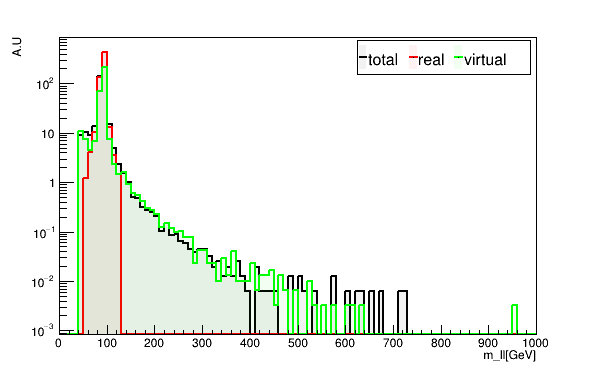

In [37]:
histos, canvas, legend = overlap_histos("m_ll(GeV)", dict_histos= Histograms, log_scale= True)

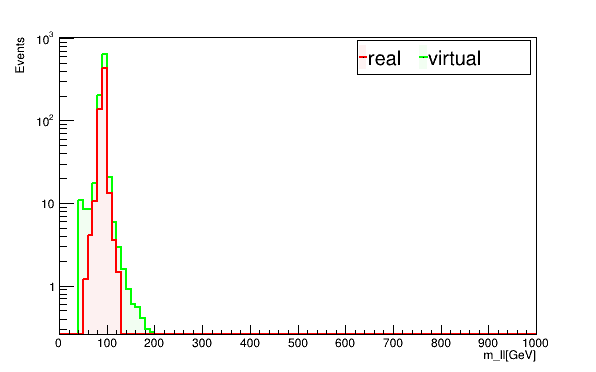

In [40]:
histos, canvas, legend = overlap_histos("m_ll(GeV)", dict_histos= Histograms, log_scale= True, stack= True)

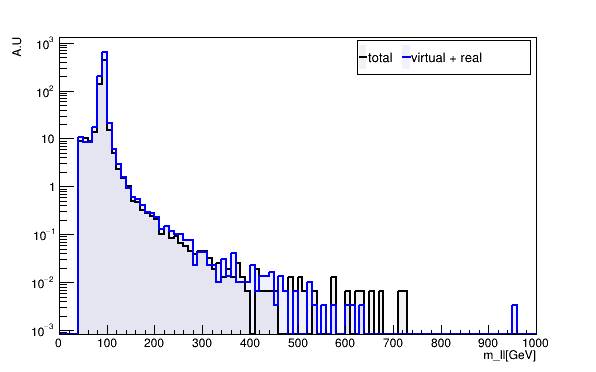

In [43]:
histos, canvas, legend = overlap_histos("m_ll(GeV)", dict_histos= Histograms, log_scale= True)

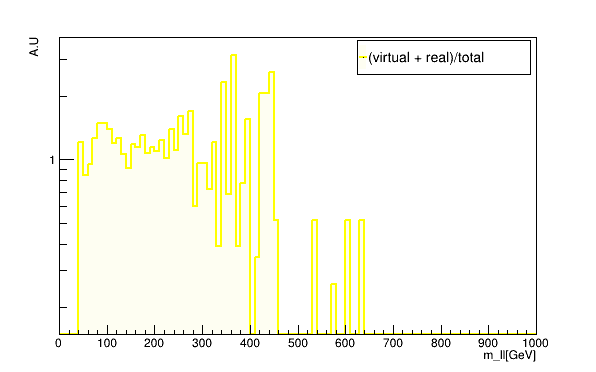

In [58]:
histos, canvas, legend = overlap_histos("m_ll(GeV)", dict_histos= Histograms, log_scale= True)

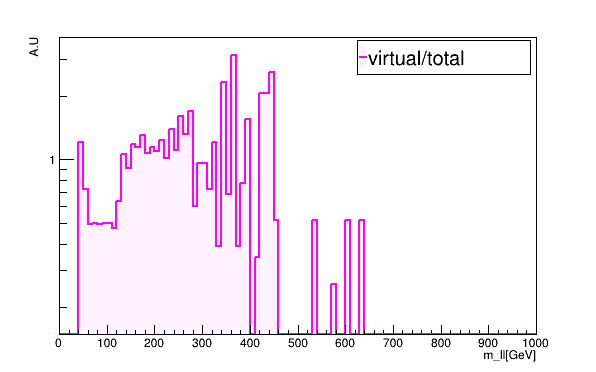

In [60]:
histos, canvas, legend = overlap_histos("m_ll(GeV)", dict_histos= Histograms, log_scale= True)